# Keyword spotting

Keyword spotting (KWS) is a typical problem defined in the context of speech processing. A special case of KWS is the case of wake word detection that is commonly used by personal digital assistants as Alexa and Siri to “wake up” when their command is spoken. This is not the case of speech recognition, that needs much more complex systems and structures, but this approach can be used to identify a set of commands to operate on a personal device.

The objective of this lab is to experiment with a workflow for training a simple network that can learn how to detect know commands in one second of audio, e.g., 'up', 'down', 'left', 'right', 'stop', 'go', 'yes', 'no'.

Some of the steps described in this document are implemented in the notebook “ml4vmm24_lab05_audio.ipynb” provided with the lab material (the current file). Activities to be performed by the student are identified with the keyword **“Task”**.

**Note.** The notebook modifies the Pytorch tutorial on [Speech Command Classification with Torchaudio](https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html) by using both Waveform and Mel Spectrogram as input to the Network Model and, optionally, using [*audio feature augmentation*](https://pytorch.org/audio/main/tutorials/audio_feature_augmentation_tutorial.html).

## Preliminaries

Before starting, review or have ready the following material:

* Lesson "14. Machine and Deep Learning for Audio" slides and recording

* Pytorch tutorial on Speech Command Classification
https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html

* Pytorch tutorial on Audio Feature Extractions to compute and represent the Mel Spectrogram
https://pytorch.org/audio/main/tutorials/audio_feature_extractions_tutorial.html#sphx-glr-tutorials-audio-feature-extractions-tutorial-py

* Pytorch tutorial on Audio Data Augmentation to extend the set of samples fo the training
https://pytorch.org/audio/stable/tutorials/audio_data_augmentation_tutorial.html



## Importing libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys
import librosa
import torchvision
import numpy as np

import matplotlib.pyplot as plt
import IPython.display as ipd
import pandas as pd

from tqdm import tqdm #mostra una barra di avanzamento(taqaddum->progresso)
%matplotlib inline

from torchsummary import summary


### Get Computational Device




In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Importing the Dataset

We use torchaudio to download and represent the dataset. Here we use
[SpeechCommands](https://arxiv.org/abs/1804.03209), which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is being accessed, and torchaudio takes care of converting the audio files to tensors. If one wants to load an audio file directly instead, `torchaudio.load()` can be used. It returns a tuple containing the newly created tensor along with the sampling frequency of the audio file (16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into standard training, validation, testing subsets.

**Note.** In order to speed up the learning process, we restrict the number of different commands to a subset of the original thirtyfive commands: ['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero'] (see the `commands` set).




In [5]:
from torchaudio.datasets import SPEECHCOMMANDS #dataset
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None, labels = {}): #subset(training,test,valid), labels (comandi che ci interessano)
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        def filter_labels(walker):
            return [ w for w in walker if os.path.split(os.path.split(w)[0])[1] in labels ]

        # labels = { 'yes', 'no' }

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes ]

        # for i, file_path in enumerate(self._walker):
        #     print(subset, get_label(file_path), file_path)
        if len(labels):
          self._walker = filter_labels(self._walker)




# Limit to a subset of all the 35 commands
commands = {'up', 'down', 'left', 'right', 'stop', 'go', 'yes', 'no'}
print("Selected command subset from the dataset: ", commands);
# Create training and testing split of the data.
train_set = SubsetSC("training", commands)
test_set = SubsetSC("testing", commands)
valid_set = SubsetSC("validation", commands)



Selected command subset from the dataset:  {'stop', 'no', 'up', 'down', 'right', 'yes', 'left', 'go'}


## Exploring the data

A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.

**Task: Waveform Plot.** Select a sample from the dataset (e.g., idx=1), plot the waveform and print its shape. Liste to the same sample with “ipd.Audio(<waveform>, <rate>)”

```
Train set length: 24713
Test set length: 3276
Sample metadata. Label: down, Speaker: 004ae714, Utterance no. 0
Shape of waveform: torch.Size([1, 16000])
  Number of channels: 1
  Number of samples: 16000
Sample rate of waveform: 16000 Hz
```

![picture](https://gist.githubusercontent.com/servetti-polito/b976ba016411f0c3905bf89e18a28899/raw/0a3cace1bcae8518e974a270c3b6fbb8acb01a7c/utterance-waveform.png)




Train set length: 24713
Test set length: 3276
Sample metadata. Label: down, Speaker: 012187a4, Utterance no. 0
Shape of waveform: torch.Size([1, 12970])
  Number of channels: 1
  Number of samples: 12970
Sample rate of waveform: 16000 Hz
durata del segnale: 0.810625s


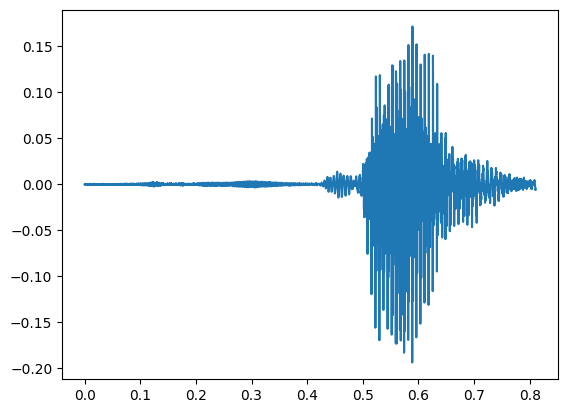

In [6]:
print(f"Train set length: {len(train_set)}")
print(f"Test set length: {len(test_set)}")

idx = 5

waveform, sample_rate, label, speaker_id, utterance_number = train_set[idx] #pip install soundfile

print(f"Sample metadata. Label: {label}, Speaker: {speaker_id}, Utterance no. {utterance_number}")
#utterance number mi dice che è la i-esima ripetizione di un comando da parte di uno speaker incontrata finora
print("Shape of waveform: {}".format(waveform.size()))
print("  Number of channels: {}".format(waveform.size()[0]))
print("  Number of samples: {}".format(waveform.size()[1]))
print("Sample rate of waveform: {} Hz".format(sample_rate))
print("durata del segnale: {}s".format(waveform.size()[1]/sample_rate))

# TASK: WAVEFORM PLOT
_=plt.plot(np.array((range(waveform.size()[1])))*1/sample_rate,np.squeeze(waveform)) #secondi x ampiezza
#crea un range che va da 0 a numero di campioni, diviso per la frequenza di campionamento per dare uno spessore a questi intervallini

Run the following cell and listen to the sample.



In [5]:
print(f"Listen to sample no. {idx} with utterance_number: {utterance_number}")
print(f" Speaker {speaker_id} saying '{label}'")
print()

# da import IPython.display as ipd
ipd.display(ipd.Audio(waveform.numpy(), rate=sample_rate))

Listen to sample no. 5 with utterance_number: 0
 Speaker 012187a4 saying 'down'



Let’s find the list of labels available in the dataset. (it takes at least 1.5 minutes)




In [8]:
print(f"Counting number of labels in the dataset (be patient) ...")

# or just list the command subset
# labels = list(commands)
counts = pd.Series(datapoint[2] for datapoint in train_set).value_counts();
labels = [ lbl for lbl, cnt in counts.items()] #lbl,count sono chiave e valore, prendo la chiave e la inserisco in una lista [], si può aggiungere un if
print(labels)
counts

Counting number of labels in the dataset (be patient) ...
['yes', 'down', 'no', 'stop', 'go', 'left', 'right', 'up']


yes      3228
down     3134
no       3130
stop     3111
go       3106
left     3037
right    3019
up       2948
Name: count, dtype: int64

## Mel Spectrogram

**Task: Mel Spectrogram.** Use _Torchaudio transforms_ to transform the sample data in an image, i.e., the Mel Spectrogram. First just use the default parameters, then follow the Pytorch tutorial on [Audio Feature Extractions](https://pytorch.org/audio/main/tutorials/audio_feature_extractions_tutorial.html#sphx-glr-tutorials-audio-feature-extractions-tutorial-py) and experiment with different _win_length_: the frame length, _hop_length_: the “stride” length, _n_fft_: the number of frequency bins, _n_mels_: the number of mel bands. A possible result is as shown in the following figure.

* Q: How many samples (power of two) is a window of about 10ms? Why 10ms are often used?

N = fs*durata_finestra

Nel nostro caso N= 16.000Hz*10ms= 160(win length)->2^8=256 usato spesso per n_fft(se >win_length sto usando zero padding per i campioni aggiuntivi, aggiungendo zero alla fine della finestra)

10ms rappresentano un bun compromesso tra risoluzione tempo e frequenza nello speach. Una finestra minore migliora risoluzione t ma peggiora f e viceversa

* Q: What is the common ratio between the window length and the hop size?

2:1 (50%) es.25ms di finestra e 12,5ms di hop size

4:1 (75%) es.25ms di finestra e 6,25ms di passo

*	Q: How many FFT bins or Mel bands are commonly used in deep learning networks? See some examples in the slides, note if the numbers depend on the sampling rate. Is the same value used for both of them or not?

FFT bins = n_fft/2+1 perchè la FFT produce uno spettro simmetrico e consideriamo solo la metà positiva (risoluzione asse frequenza)

Definisco il numero di Mel bands che voglio(dipendente dal task) e raggruppo gli FFT bins in queste bande(con un filtro triangolare) così da avere più dettaglio nelle frequenze bassse e meno in quelle alte, poi sommo l'energia di ogni bin per gruppo e ne faccio il logaritmo per mimare la percezione umana





*	H: Remember to compute the spectrogram values in dB (i.e., log scale).


![picture](https://gist.githubusercontent.com/servetti-polito/b976ba016411f0c3905bf89e18a28899/raw/fc17ffa3e44ef402e5995619cf42f6908f88d84e/mel-spectrogram.png)

Shape of spectrogram: (128, 163)


c:\Users\cancr\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


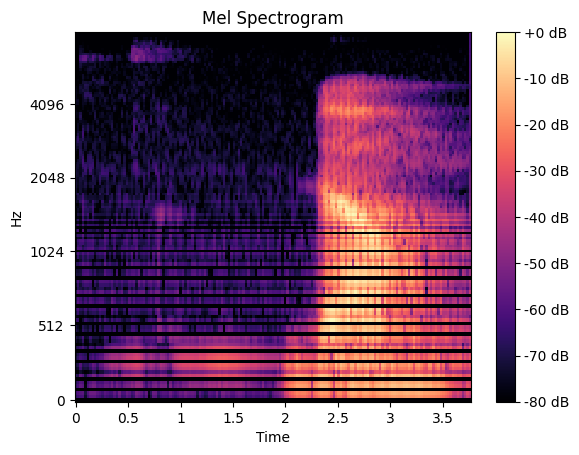

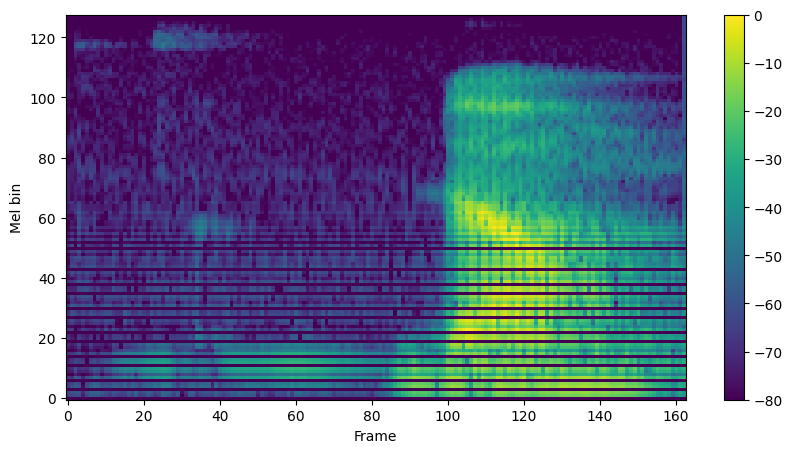

In [7]:
# TASK. MEL SPECTROGRAM
# uso librosa, ma si può usare anche torchaudio.transforms.MelSpectrogram() e .AmplitudeToDB()

#mel_spect = librosa.feature.melspectrogram(y=y, sr=16.000Hz, n_fft=2048, hop_length=1024)
#weveform è un tensore di dim 1x12.970 -> quindi lo trasformo in numpy array e prendo il primo e unico canale
mel_spect = librosa.feature.melspectrogram(y=waveform[0].numpy(),sr=sample_rate, n_fft=256, hop_length=80, win_length=160)
#il mel spectrogram calcola solo l'energia nelle bande ma in modo lineare per rappresentare l'energia in modo conforme alla percezione umana(più sensibile alle basse frequenze)    
#di queste bande, quindi la scala deve essere trasformata in logaritmica perchè le ottave avanzano a potenze di 2
mel_spect_db = librosa.power_to_db(mel_spect, ref=np.max)


# ho trovato due modi per rappresentarlo
librosa.display.specshow(mel_spect_db, y_axis='mel', fmax=sample_rate/2, x_axis='time')
plt.title('Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')

print("Shape of spectrogram: {}".format(mel_spect_db.shape))

plt.figure(figsize=(10,5))
plt.xlabel('Frame');
plt.ylabel('Mel bin');
plt.imshow(mel_spect_db, origin="lower", aspect="auto", interpolation="nearest")
plt.colorbar()
plt.show()



## Formatting the data



Functions `label_to_index` and `index_to_label` are used to map (and encode) each word with its index in the list of labels.



In [8]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(0) --> yes


To turn a list of data point made of audio recordings and utterances into two batched tensors for the model, we implement a collate function which is used by the PyTorch DataLoader that allows us to iterate over a dataset by batches. Please see the documentation for more information about working with a [collate function](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn).

Each sequence is eventually padded with zeros so that tensors in a batch will have all the same length.


In [9]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

## Generic functions for training and testing the network model

Now let’s define a *generic* training function that will feed our training data into the model and perform the backward pass and optimization steps. The network will then be tested after each epoch to see how the accuracy varies during the training.

The *generic* function receives as parameters:
* The **trasform** function to apply to the data (or `None`).
* The **criterion** function for computing the loss.
* The **optimizer** to be used during the process.

In [10]:
def train(model, transform, criterion, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        if transform != None :
          data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        # loss = F.nll_loss(output.squeeze(), target)
        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print()
            print(f"       Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]")
            print(f"       Loss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)

        # record loss
        losses.append(loss.item())

Now that we have a *generic* training function, we need to make a *generic* one for testing the networks accuracy. We will set the model to `eval()` mode and then run inference on the test dataset. Calling `eval()` sets the training variable in all modules in the network to false. Certain layers like batch normalization and dropout layers behave differently during training so this step is crucial for getting correct results.

In [11]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, transform, criterion, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        if transform != None :
          data = transform(data)

        output = model(data)
        loss = criterion(output, target)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)


    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Define a *generic* predictor end evaluate function to be used in the evaluation phase.

In [12]:
# Returns the predict function binded to the model and transform
def predictor(model, transform):

    def p(tensor):
      # Use the model to predict the label of the waveform
      tensor = tensor.to(device)
      tensor = transform(tensor)
      tensor = model(tensor.unsqueeze(0))
      tensor = get_likely_index(tensor)
      tensor = index_to_label(tensor.squeeze())
      return tensor

    return p


def evaluate(losses, predict, eval_set):

  # Let's plot the training loss versus the number of iteration.
  plt.plot(losses);
  plt.title("training loss");

  cnt = 0

  for i, (waveform, sample_rate, utterance, *_) in enumerate(eval_set):
      try:
          output = predict(waveform)
      except:
          None
          # print("An exception occurred ", utterance, output)
      if output != utterance:
          # ipd.Audio(waveform.numpy(), rate=sample_rate)
          # print(f"Data point #{i}. Expected: {utterance}. Predicted: {output}.")
          print('-', end="")
      else:
          print('*', end="")
          cnt = cnt + 1
      if(not((i+1) % 100)):
        print()

  return cnt/len(eval_set)

## End-to-end model (i.e., no data processing)

As a first example we will use **the raw audio data** and a 1D convolutional neural network. Usually more advanced transforms are applied to the audio data, however CNNs can also be used to process the raw data.

**Task.** Build a network model with architecture defined as M5 in the paper [Very deep convolutional neural networks for raw waveforms](https://arxiv.org/pdf/1610.00087.pdf).

An important aspect of models processing raw audio data is the receptive field of their first layer’s filters. This model’s first filter is length 80 so when processing audio sampled at 8kHz the receptive field is around 10ms (and at 4kHz, around 20 ms). This size is similar to speech processing applications that often use receptive fields ranging from 20ms to 40ms.

![picture](https://gist.githubusercontent.com/servetti-polito/b976ba016411f0c3905bf89e18a28899/raw/d00e2d2e3c00b96c68be26d3ee3c2deaec106868/m5-model.small.jpg)

**Task.** For the waveform, we define a **transform function** to downsample the audio (see `torchaudio.transforms.Resample`) for faster processing without losing too much of the classification power.
* Q: Which _reduced_ sample rate can be used to preserve speech information?

We don’t need to apply other transformations here. It is common for some datasets though to have to reduce the number of channels (say from stereo to mono) by either taking the mean along the channel dimension, or simply keeping only one of the channels. Since SpeechCommands uses a single channel for audio, this is not needed here.

In [ ]:
## TASK. BUILD THE NETWORK MODEL
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=8, stride=4, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, 2*n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(2*n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(2*n_channel, 4*n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(4*n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(4*n_channel, n_output)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

model_M5 = M5(n_input=1, n_output=len(labels)).to(device)
print(model_M5)
summary(model_M5, (1, 16000))

## TASK. BUILD THE TRANSFORM PIPELINE
# See pipeline at https://pytorch.org/audio/stable/transforms.html

transform_M5 = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128)

criterion_M5 = lambda o,t: nn.NLLLoss()(o.squeeze(),t)


M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=128, out_features=8, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 32, 996]           2,592
       BatchNorm1d-2              [-1, 32,

c:\Users\cancr\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


### Training and testing

Finally, we can train and test the network. The network will be tested after each epoch to see how the accuracy varies during the training.

The network should be more than 65% accurate on the test set after 2 epochs, and 85% after 21 epochs.

Note. We will use the same optimization technique used in the paper, an Adam optimizer with weight decay set to 0.0001. If the number of epoch is greater than 20, an optimizer can be added in order to decrease the weight decay.

**Task.** Train and test the network model. Assign to the `model`, `transform`, and `criterion` variables the classes or functions to be used for the specific model at hand.   




In [10]:
# CUSTOMIZE with the proper model, transform and criterion (either for 1D or 2D networks)
model = model_M5
transform = transform_M5
criterion = criterion_M5

log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
model = model.to(device)
transform = transform.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
## At first, we will train with a learning rate of 0.01, but we will use a scheduler to decrease it to 0.001 during training after 20 epochs.
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

predict = predictor(model, transform)

print("Number of parameters: %s" % sum(p.numel() for p in model.parameters() if p.requires_grad))
print(model)

with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, transform, criterion, optimizer, epoch, log_interval)
        test(model, transform, criterion, epoch)
#        scheduler.step()


NameError: name 'train_loader' is not defined

### Evaluate the model.

* Plot the training loss versus the number of iterations

* Look at the samples in the validation set and see how the model performs on it


--**-**---*****-**---**-*-*-******-***--*******-********-**--*-****-*--*-**---****-*-*-*-*****-***--
--*--***-***--****-***-****-****--*****--*****************-*-**-***-*---**********--*****--*-***-**-
*-----***--***----********-****-**-**---*-*--*-*--****--********--***--******--**-*****--*-*******-*
**-*-****-*-*******-*---*************-**-**********-**--*---***-*******---********--*******-*-******
************---***************************************************-***-************-********-*****-*
**-*****************************************************************-**********--******-*-*-********
******-****************-**********-**********-***********-*************-*********************-******
***********************************-***-***---****-****-*-*---*-**--**-*****-*****-**-*-*-*******---
******-*****---*-*---*******-**-*****---*****-***********--********--***--****--***--***--****-*****
*--*--*********-********--*****--**-******--**---***-*--****---*-**--*-*-***--*-*---*-*-*-*

0.7098078867542973

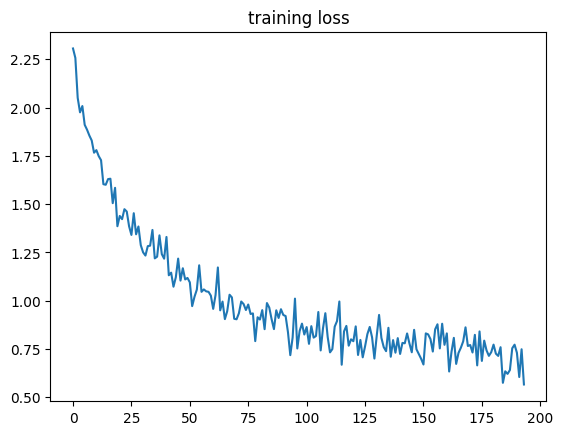

In [ ]:
# Evaluate on the validation set
print()
perc = evaluate(losses, predict, valid_set)
print("Validation set prediction accuracy: ", perc)


## Mel spectrogram model (with 2D transformation)



**Task: Mel Spectrogram Transform.** Starting from the data visualization section where the Mel Spectrogram of a sample has been computed, build _transform pipeline_ to convert the audio samples to the Mel spectrogram representation.

* H: check the shape of the 2D array before using it as input to the model, i.e. the number of bins (values) both in the time and frequency domain.


**Task. 2D Newtork Model.**  Define a convolutional neural network (CNN) starting from the architecture implemented in Lab n.03 for the fashion MINST dataset and adapting its structure to the data at hand.




In [ ]:
## TASK. BUILD THE NETWORK MODEL

# class CNN(nn.Module):

# model_CNN =

## TASK. BUILD THE TRANSFORM PIPELINE
# See pipeline at https://pytorch.org/audio/stable/transforms.html

# transform_CNN =

# criterion_CNN =

### Training and testing

**Task.** Train and test the network model. _Assign to the model, transform, and criterion variables the classes or functions to be used for the specific model at hand._

* Q: Do the result change using the default MelSpectrogram transform or the customized one with different window, fft, and mel parameters?

* Repeat the processing, training and test the results. Consider changing the input representation, the network architecture, or the network hyper-parameters

* Plot the training loss versus the number of iterations.

* Look at the prediction performance and annotate the results for the comparison with the 1D model.

In [ ]:
# UNCOMMENT and CUSTOMIZE with the proper model, transform and criterion (either for 1D or 2D networks)
model = model_CNN
transform = transform_CNN
criterion = criterion_CNN

log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
model = model.to(device)
transform = transform.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
#optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                              steps_per_epoch=int(len(train_loader)),
                                              epochs=n_epoch,
                                              anneal_strategy='linear')

predict = predictor(model, transform)


print("Number of parameters: %s" % sum(p.numel() for p in model.parameters() if p.requires_grad))
print(model)

with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, transform, criterion, optimizer, epoch, log_interval)
        test(model, transform, criterion, epoch)
#        scheduler.step()

Number of parameters: 468011
CnnClassifier(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3200, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=35, bias=True)
)


  0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0.00909090909090909/2 [00:00<03:08, 94.65s/it]


       Train Epoch: 1 [0/24713 (0%)]
       Loss: 4.394987


 10%|▉         | 0.19090909090909094/2 [00:20<03:28, 115.03s/it]


       Train Epoch: 1 [5120/24713 (21%)]
       Loss: 3.329193


 19%|█▊        | 0.3727272727272728/2 [00:38<02:30, 92.54s/it]


       Train Epoch: 1 [10240/24713 (41%)]
       Loss: 3.112451


 28%|██▊       | 0.5545454545454543/2 [00:56<02:14, 93.28s/it]


       Train Epoch: 1 [15360/24713 (62%)]
       Loss: 2.911855


 37%|███▋      | 0.7363636363636351/2 [01:15<02:45, 131.32s/it]


       Train Epoch: 1 [20480/24713 (82%)]
       Loss: 2.792427


 50%|████▉     | 0.9999999999999972/2 [01:40<01:36, 96.65s/it]


Test Epoch: 1	Accuracy: 831/3276 (25%)



 50%|█████     | 1.0090909090909064/2 [01:42<01:50, 111.22s/it]


       Train Epoch: 2 [0/24713 (0%)]
       Loss: 2.726279


 60%|█████▉    | 1.1909090909090871/2 [02:00<01:21, 100.60s/it]


       Train Epoch: 2 [5120/24713 (21%)]
       Loss: 2.561893


 69%|██████▊   | 1.372727272727268/2 [02:18<00:57, 91.61s/it] 


       Train Epoch: 2 [10240/24713 (41%)]
       Loss: 2.606698


 78%|███████▊  | 1.5545454545454487/2 [02:36<00:44, 99.65s/it]


       Train Epoch: 2 [15360/24713 (62%)]
       Loss: 2.467244


 87%|████████▋ | 1.7363636363636294/2 [02:55<00:27, 105.48s/it]


       Train Epoch: 2 [20480/24713 (82%)]
       Loss: 2.321518


100%|█████████▉| 1.9999999999999916/2 [03:21<00:00, 100.89s/it]


Test Epoch: 2	Accuracy: 1013/3276 (31%)



--**-**---*****-**---**-*-*-******-***--*******-********-**--*-****-*--*-**---****-*-*-*-*****-***--
--*--***-***--****-***-****-****--*****--*****************-*-**-***-*---**********--*****--*-***-**-
*-----***--***----********-****-**-**---*-*--*-*--****--********--***--******--**-*****--*-*******-*
**-*-****-*-*******-*---*************-**-**********-**--*---***-*******---********--*******-*-******
************---***************************************************-***-************-********-*****-*
**-*****************************************************************-**********--******-*-*-********
******-****************-**********-**********-***********-*************-*********************-******
***********************************-***-***---****-****-*-*---*-**--**-*****-*****-**-*-*-*******---
******-*****---*-*---*******-**-*****---*****-***********--********--***--****--***--***--****-*****
*--*--*********-********--*****--**-******--**---***-*--****---*-**--*-*-***--*-*---*-*-*-*

0.7098078867542973

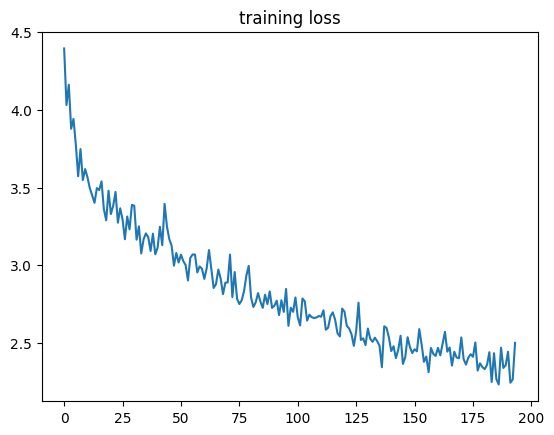

In [ ]:
# Evaluate on the validation set
print()
perc = evaluate(losses, predict, valid_set)
print("Validation set prediction accuracy: ", perc)
